In [10]:
import sagemaker
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from io import BytesIO
import tarfile

# Session setup
session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
region = session.boto_region_name

# Column names (Lapsed first, matching our preprocessed data)
col_names = ['Lapsed', 'Distribution_channel', 'Seniority', 'Policies_in_force', 
             'Max_policies', 'Max_products', 'Payment', 'Premium', 'Cost_claims_year',
             'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk', 
             'Area', 'Second_driver', 'Year_matriculation', 'Power', 'Cylinder_capacity',
             'Value_vehicle', 'N_doors', 'Type_fuel', 'Length', 'Weight', 'Age', 
             'Years_driving', 'Customer_tenure_days']

feature_names = col_names[1:]  # Everything except Lapsed

print(f"Bucket: {bucket}")
print(f"Region: {region}")
print(f"Features: {len(feature_names)}")

Bucket: sagemaker-us-east-1-360138725243
Region: us-east-1
Features: 25


In [11]:
sm_client = boto3.client('sagemaker')
s3_client = boto3.client('s3')

baseline_job = 'insurance-lapse-baseline-2026-02-12-15-18-48-636'
job_details = sm_client.describe_training_job(TrainingJobName=baseline_job)
model_s3_path = job_details['ModelArtifacts']['S3ModelArtifacts']

print(f"Training job: {baseline_job}")
print(f"Model artifact: {model_s3_path}")

# Download and extract the model
s3_key = model_s3_path.replace(f's3://{bucket}/', '')
response = s3_client.get_object(Bucket=bucket, Key=s3_key)
model_bytes = response['Body'].read()

with tarfile.open(fileobj=BytesIO(model_bytes), mode='r:gz') as tar:
    tar.extractall(path='/tmp/model')

# Load into XGBoost
model = xgb.Booster()
model.load_model('/tmp/model/xgboost-model')

print(f"\nModel loaded successfully!")
print(f"Number of trees: {model.num_boosted_rounds()}")

Training job: insurance-lapse-baseline-2026-02-12-15-18-48-636
Model artifact: s3://sagemaker-us-east-1-360138725243/models/insurance-lapse-baseline-2026-02-12-15-18-48-636/output/model.tar.gz

Model loaded successfully!
Number of trees: 200


/tmp/ipykernel_302/3448533736.py:17: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path='/tmp/model')


In [12]:
# ============================================
# FEATURE IMPORTANCE
# ============================================

# Get feature importance scores (by 'gain' - how much each feature improves predictions)
importance = model.get_score(importance_type='gain')

# Map feature indices (f0, f1, f2...) to actual feature names
importance_named = {}
for key, value in importance.items():
    idx = int(key.replace('f', ''))
    importance_named[feature_names[idx]] = value

# Sort by importance
importance_sorted = dict(sorted(importance_named.items(), key=lambda x: x[1], reverse=True))

# Display as a table
print("=== Feature Importance (by Gain) ===\n")
print(f"{'Rank':>4} {'Feature':<25} {'Importance':>12}")
print("-" * 45)
for i, (feature, score) in enumerate(importance_sorted.items(), 1):
    print(f"{i:>4} {feature:<25} {score:>12.2f}")

=== Feature Importance (by Gain) ===

Rank Feature                     Importance
---------------------------------------------
   1 Policies_in_force               108.51
   2 Cost_claims_year                101.09
   3 Seniority                        95.62
   4 Customer_tenure_days             92.69
   5 Payment                          71.19
   6 Max_policies                     69.80
   7 R_Claims_history                 69.62
   8 N_claims_year                    68.16
   9 Distribution_channel             49.36
  10 Year_matriculation               34.41
  11 Second_driver                    28.34
  12 N_claims_history                 21.33
  13 Premium                          20.17
  14 N_doors                          19.12
  15 Years_driving                    17.37
  16 Value_vehicle                    16.13
  17 Type_risk                        14.57
  18 Weight                           14.13
  19 Max_products                     13.37
  20 Age                            

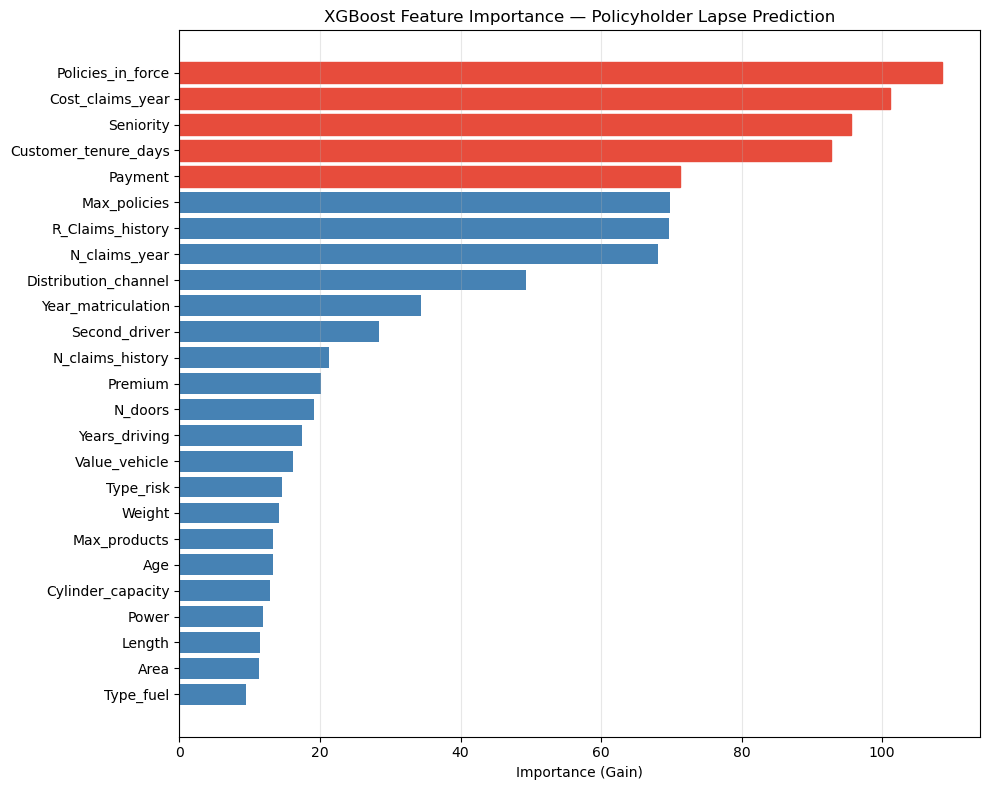

In [13]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))

features = list(importance_sorted.keys())
scores = list(importance_sorted.values())

# Horizontal bar chart, most important at the top
bars = ax.barh(range(len(features)-1, -1, -1), scores, color='steelblue')

# Highlight top 5 in a different color
for i, bar in enumerate(bars):
    if i < 5:
        bar.set_color('#e74c3c')

ax.set_yticks(range(len(features)-1, -1, -1))
ax.set_yticklabels(features)
ax.set_xlabel('Importance (Gain)')
ax.set_title('XGBoost Feature Importance — Policyholder Lapse Prediction')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
import subprocess
subprocess.check_call(['pip', 'install', 'shap', '-q'])
import shap

# Load the validation data
val_df = pd.read_csv(f's3://{bucket}/data/processed/validation/validation.csv', 
                     header=None, names=col_names)

val_y = val_df['Lapsed'].values
val_X = val_df.drop(columns=['Lapsed'])

# Convert to DMatrix (XGBoost's internal data format)
dval = xgb.DMatrix(val_X, feature_names=feature_names)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dval)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Each row is a customer, each column is a feature's contribution")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.5.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
autogluon-timeseries 1.5.0 requires chronos-forecasting<2.4,>=2.2.2, which is not installed.
autogluon-timeseries 1.5.0 requires einops<1,>=0.7, which is not installed.
autogluon-timeseries 1.5.0 requires peft<0.18,>=0.13.0, which is not installed.
amazon-sagemaker-jupyter-ai-q-developer 1.2.9 requires numpy<=2.0.1, but you have numpy 2.3.5 which is incompatible.
amazon-sagemaker-sql-magic 0.1.4 requires numpy<2, but you have numpy 2.3.5 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.3.5 which is incompatible.
gluonts 0.16.2 requires numpy<2.2,>=1.16, but you have numpy 2.3.5 which is incompatible.
langchain-aws 0.2.19 requires boto3>=1.37.24, but you have boto3 1.37.3 which is incompat

SHAP values shape: (21111, 25)
Each row is a customer, each column is a feature's contribution


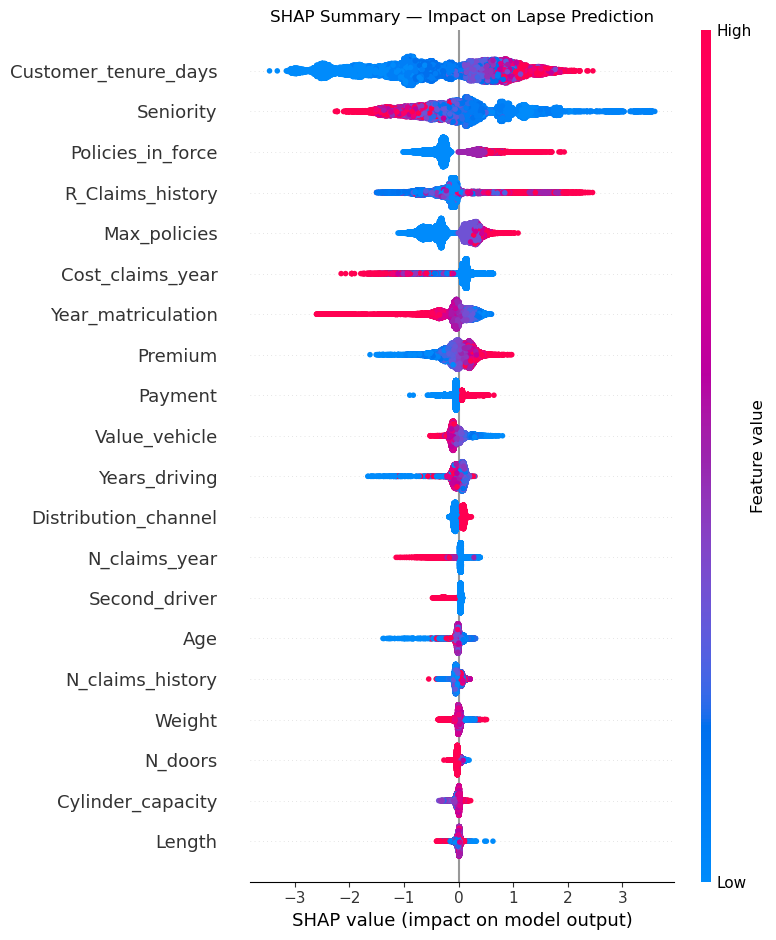

In [15]:
# ============================================
# SHAP ANALYSIS
# ============================================

# Summary plot - shows all features and how they impact predictions
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, val_X, feature_names=feature_names, show=False)
plt.title('SHAP Summary — Impact on Lapse Prediction')
plt.tight_layout()
plt.savefig('../shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# ============================================
# INDIVIDUAL CUSTOMER EXPLANATIONS
# ============================================

# Get model predictions for the validation set
val_predictions = model.predict(dval)

# Find a high-risk customer (high lapse probability)
high_risk_idx = np.argmax(val_predictions)
high_risk_prob = val_predictions[high_risk_idx]

# Find a low-risk customer
low_risk_idx = np.argmin(val_predictions)
low_risk_prob = val_predictions[low_risk_idx]

print(f"High-risk customer (index {high_risk_idx}): {high_risk_prob:.2%} lapse probability")
print(f"Low-risk customer (index {low_risk_idx}): {low_risk_prob:.2%} lapse probability")

High-risk customer (index 468): 99.87% lapse probability
Low-risk customer (index 5532): 0.10% lapse probability


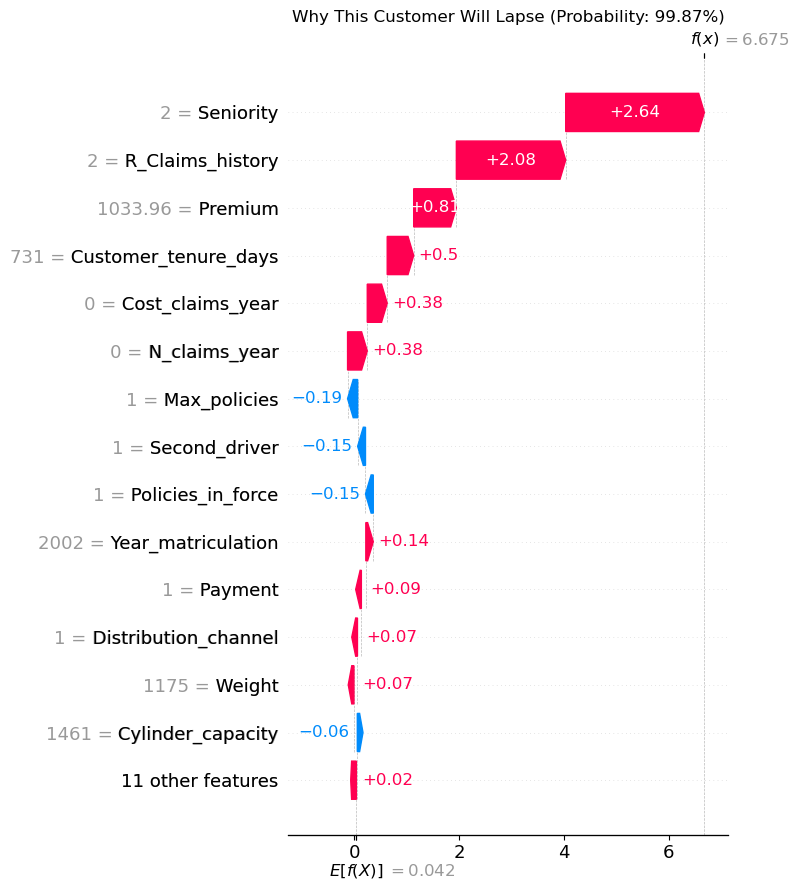


=== High-Risk Customer Profile ===
  Distribution_channel      = 1.0
  Seniority                 = 2.0
  Policies_in_force         = 1.0
  Max_policies              = 1.0
  Max_products              = 1.0
  Payment                   = 1.0
  Premium                   = 1033.96
  Cost_claims_year          = 0.0
  N_claims_year             = 0.0
  N_claims_history          = 2.0
  R_Claims_history          = 2.0
  Type_risk                 = 3.0
  Area                      = 0.0
  Second_driver             = 1.0
  Year_matriculation        = 2002.0
  Power                     = 80.0
  Cylinder_capacity         = 1461.0
  Value_vehicle             = 18545.0
  N_doors                   = 3.0
  Type_fuel                 = 0.0
  Length                    = 4.209
  Weight                    = 1175.0
  Age                       = 46.6
  Years_driving             = 22.6
  Customer_tenure_days      = 731.0


In [18]:
# Waterfall plot for the HIGH-RISK customer
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[high_risk_idx],
        base_values=explainer.expected_value,
        data=val_X.iloc[high_risk_idx],
        feature_names=feature_names
    ),
    show=False,
    max_display=15
)
plt.title(f'Why This Customer Will Lapse (Probability: {high_risk_prob:.2%})')
plt.tight_layout()
plt.savefig('../shap_high_risk.png', dpi=150, bbox_inches='tight')
plt.show()

# Show the actual feature values for this customer
print("\n=== High-Risk Customer Profile ===")
for feature in feature_names:
    print(f"  {feature:<25} = {val_X.iloc[high_risk_idx][feature]}")

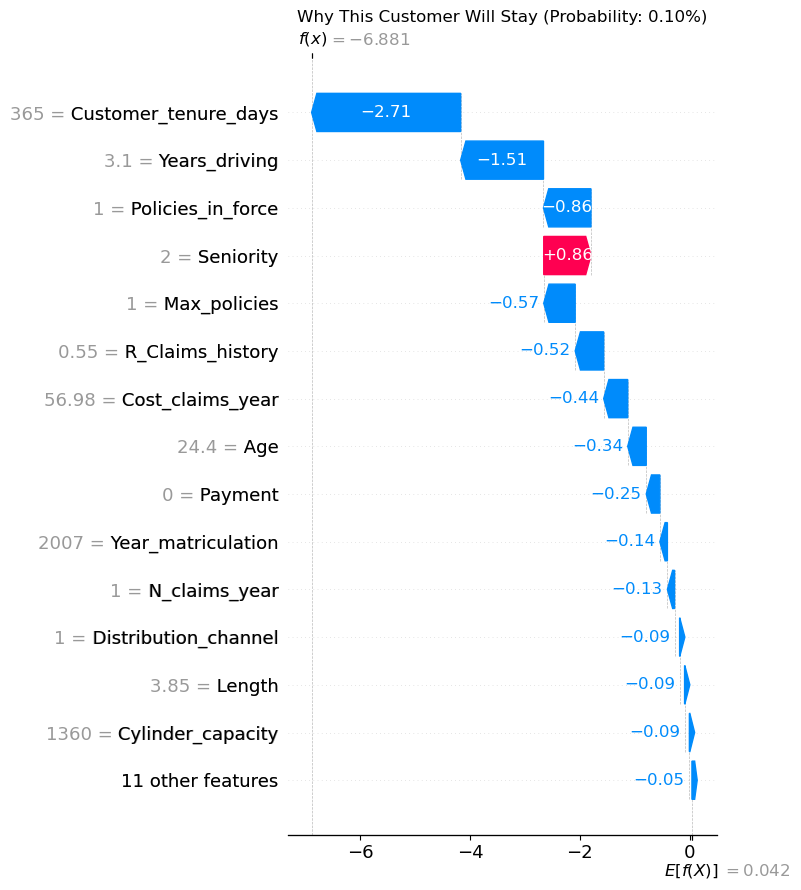


=== Low-Risk Customer Profile ===
  Distribution_channel      = 1.0
  Seniority                 = 2.0
  Policies_in_force         = 1.0
  Max_policies              = 1.0
  Max_products              = 1.0
  Payment                   = 0.0
  Premium                   = 390.22
  Cost_claims_year          = 56.98
  N_claims_year             = 1.0
  N_claims_history          = 1.0
  R_Claims_history          = 0.55
  Type_risk                 = 3.0
  Area                      = 1.0
  Second_driver             = 0.0
  Year_matriculation        = 2007.0
  Power                     = 90.0
  Cylinder_capacity         = 1360.0
  Value_vehicle             = 14960.0
  N_doors                   = 5.0
  Type_fuel                 = 1.0
  Length                    = 3.85
  Weight                    = 1126.0
  Age                       = 24.4
  Years_driving             = 3.1
  Customer_tenure_days      = 365.0


In [19]:
# Waterfall plot for the LOW-RISK customer
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[low_risk_idx],
        base_values=explainer.expected_value,
        data=val_X.iloc[low_risk_idx],
        feature_names=feature_names
    ),
    show=False,
    max_display=15
)
plt.title(f'Why This Customer Will Stay (Probability: {low_risk_prob:.2%})')
plt.tight_layout()
plt.savefig('../shap_low_risk.png', dpi=150, bbox_inches='tight')
plt.show()

# Show the actual feature values
print("\n=== Low-Risk Customer Profile ===")
for feature in feature_names:
    print(f"  {feature:<25} = {val_X.iloc[low_risk_idx][feature]}")

In [20]:
# ============================================
# BUSINESS NARRATIVE
# ============================================

# Calculate mean absolute SHAP values per feature (overall impact)
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': mean_shap
}).sort_values('Mean_SHAP', ascending=False)

print("=" * 70)
print("BUSINESS INSIGHTS: What Drives Policyholder Lapse?")
print("=" * 70)

print("\n📊 TOP LAPSE DRIVERS (ranked by impact on predictions):\n")
for i, row in shap_importance.head(10).iterrows():
    print(f"  {shap_importance.index.get_loc(i)+1:>2}. {row['Feature']:<25} (impact: {row['Mean_SHAP']:.3f})")

print("\n" + "=" * 70)
print("ACTIONABLE RECOMMENDATIONS FOR RETENTION TEAM:")
print("=" * 70)

print("""
1. EARLY INTERVENTION PROGRAM
   Drivers: Seniority, Customer_tenure_days
   Action: The first 1-2 years are critical. Implement a structured 
   onboarding program with touchpoints at 30, 90, and 365 days.
   New customers with low seniority are the highest flight risk.

2. CLAIMS EXPERIENCE MANAGEMENT  
   Drivers: R_Claims_history, Cost_claims_year, N_claims_year
   Action: After a claim, proactively contact the customer before 
   renewal. Explain any premium changes and offer retention incentives.
   Claims drive premium increases, which drive lapse.

3. CROSS-SELL AS RETENTION
   Drivers: Policies_in_force, Max_policies
   Action: Customers with a single policy have nothing anchoring them.
   Prioritize cross-selling home, umbrella, or life insurance to 
   single-policy holders. Multi-policy customers rarely lapse.

4. PAYMENT METHOD OPTIMIZATION
   Drivers: Payment
   Action: Encourage monthly payment plans over annual. Yearly payers 
   face the full premium shock at once. Monthly payers absorb increases 
   gradually and are less likely to shop around.

5. PREMIUM SENSITIVITY MONITORING
   Drivers: Premium
   Action: Flag customers whose premium exceeds a threshold or increases
   by more than 15% at renewal. These customers are actively incentivized
   to comparison shop.
""")

BUSINESS INSIGHTS: What Drives Policyholder Lapse?

📊 TOP LAPSE DRIVERS (ranked by impact on predictions):

   1. Customer_tenure_days      (impact: 1.042)
   2. Seniority                 (impact: 0.724)
   3. Policies_in_force         (impact: 0.399)
   4. R_Claims_history          (impact: 0.390)
   5. Max_policies              (impact: 0.381)
   6. Cost_claims_year          (impact: 0.248)
   7. Year_matriculation        (impact: 0.234)
   8. Premium                   (impact: 0.203)
   9. Payment                   (impact: 0.112)
  10. Value_vehicle             (impact: 0.108)

ACTIONABLE RECOMMENDATIONS FOR RETENTION TEAM:

1. EARLY INTERVENTION PROGRAM
   Drivers: Seniority, Customer_tenure_days
   Action: The first 1-2 years are critical. Implement a structured 
   onboarding program with touchpoints at 30, 90, and 365 days.
   New customers with low seniority are the highest flight risk.

2. CLAIMS EXPERIENCE MANAGEMENT  
   Drivers: R_Claims_history, Cost_claims_year, N_claims